<div id="colab_button">
  <h1>Normalization in BastionLab</h1>
  <a target="_blank" href="https://colab.research.google.com/github/mithril-security/bastionlab/blob/v0.3.7/docs/docs/tutorials/normalization.ipynb"> 
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</div>
______________________________________________________

Normalization is a common data pre-processing technique used prior to ML model fitting. In this tutorial, we are going to take a look at how to use our zscore_scale and min-max normalization methods to make normalization simple in BastionLab. Normalization methods are used to avoid creating a bias due to different variables being measured at different scales and thus not contributing equally to the machine learning process.

BastionLab implements the two most common normalization methods for ML: min-max and z-score or standardization. So let's dive into how we can use these two methods on a RemoteLazyFrame!

## Pre-requisites

________________________________________________

### Installation

In order to run this notebook, we need to:
- Have [Python3.7](https://www.python.org/downloads/) (or greater) and [Python Pip](https://pypi.org/project/pip/) installed
- Install [BastionLab](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/)

We'll do so by running the code block below. 

>If you are running this notebook on your machine instead of [Google Colab](https://colab.research.google.com/github/mithril-security/bastionlab/blob/v0.3.6/docs/docs/tutorials/data_cleaning.ipynb), you can see our [Installation page](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/) to find the installation method that best suits your needs.

In [29]:
# pip packages
!pip install bastionlab
!pip install bastionlab_server

### Launch and connect to the server

In [30]:
# launch bastionlab_server test package
import bastionlab_server

srv = bastionlab_server.start()

>*Note that the bastionlab_server package we install here was created for testing purposes. You can also install BastionLab server using our Docker image or from source (especially for non-test purposes). Check out our [Installation Tutorial](../getting-started/installation.md) for more details.*

In [31]:
# connecting to the server
from bastionlab import Connection

connection = Connection("localhost")
client = connection.client

### Upload the dataframe to the server

For this tutorial, we'll create a dataset with four columns and rows.

In [32]:
import polars as pl

df1 = pl.DataFrame(
    {
        "Col A": [180000, 360000, 230000, 60000],
        "Col B": [110, 905, 230, 450],
        "Col C": [18.9, 23.4, 14.0, 13.5],
        "Col D": [1400, 1800, 1300, 1500],
    }
)


We'll quickly upload the dataset to the server with an open safety policy, since setting up BastionLab is not the focus of this tutorial. It will allows us to demonstrate features without having to approve any data access requests. You can check out how to define a safe privacy policy [here](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/defining_policy_privacy/).

In [33]:
from bastionlab.polars.policy import Policy, TrueRule, Log

policy = Policy(safe_zone=TrueRule(), unsafe_handling=Log(), savable=True)

rdf = client.polars.send_df(df1, policy=policy)
rdf.collect().fetch()

Col A,Col B,Col C,Col D
i64,i64,f64,i64
180000,110,18.9,1400
360000,905,23.4,1800
230000,230,14.0,1300
60000,450,13.5,1500


<div class="warning">
<b>This policy is not suitable for production.</b> Please note that we <i>only</i> use it for demonstration purposes, to avoid having to approve any data access requests in the tutorial. <br></div> 

## Normalization strategies
__________________________________________________________

### Min-max normalization

The min-max approach (often called normalization) rescales the feature to a hard and fast range of [0,1] by subtracting the minimum value of the feature then dividing by the range.

We can apply min-max normalization to one or multiple columns by calling the `minmax` method on our `RemoteLazyFrame` with either the string name of one column or a list of string names of multiple columns.

In [34]:
columns = ["Col A", "Col B", "Col C", "Col D"]
mm = rdf.minmax_scale(columns).collect().fetch()
mm

Col A,Col B,Col C,Col D
f64,f64,f64,f64
0.4,0.0,0.545455,0.2
1.0,1.0,1.0,1.0
0.566667,0.150943,0.050505,0.0
0.0,0.427673,0.0,0.4


The z-score method (often called standardization) transforms the info into distribution with a mean of 0 and a typical deviation of 1. 
Each standardized value is computed by subtracting the mean of the corresponding feature then dividing by the quality deviation.

We can use the z-score method in BastionLab by using the `zscore_scale` RemoteLazyFrame method. 

<AxesSubplot: >

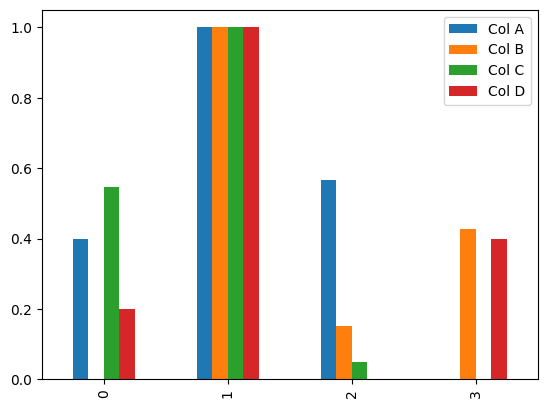

In [35]:
import matplotlib.pyplot as plt

mm.to_pandas().plot(kind="bar")

In [36]:
z = rdf.zscore_scale(columns).collect().fetch()
z

Col A,Col B,Col C,Col D
f64,f64,f64,f64
-0.221422,-0.895492,0.311486,-0.46291
1.227884,1.373564,1.278167,1.38873
0.181163,-0.552993,-0.741122,-0.92582
-1.187625,0.074922,-0.848531,0.0


<AxesSubplot: >

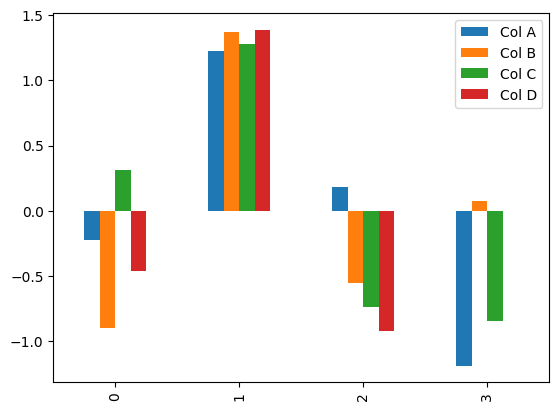

In [37]:
z.to_pandas().plot(kind="bar")

In [38]:
connection.close()
bastionlab_server.stop(srv)

BastionLab's server already stopped


False